In [1]:
import matplotlib.pyplot as plt

# --- 中文顯示設定 ---
# 加上這兩行來正常顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 指定支援中文的字體
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示問題
# ---

# ... 接著是您其他的 import 和程式碼 ...
# import os
# import numpy as np
# from PIL import Image

正在顯示圖片: 0108518d1e.png


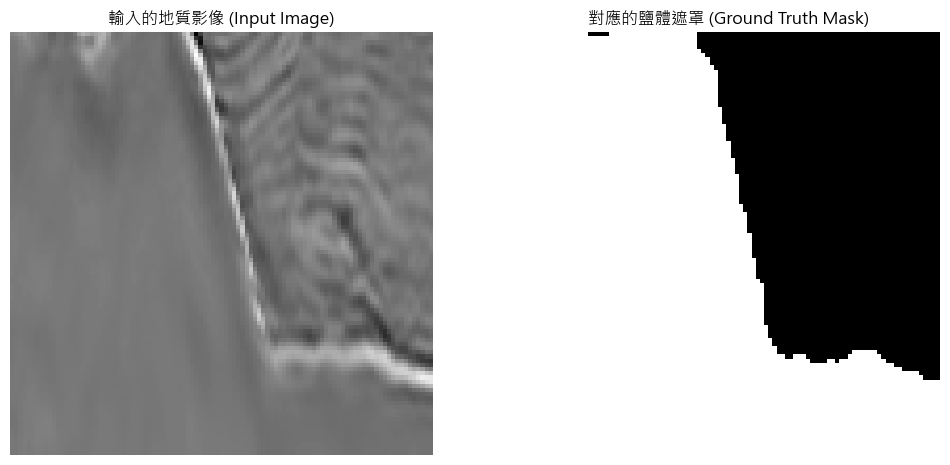

遮罩中的像素值 (Pixel values in the mask): [  0 255]


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- 步驟 1: 探索與視覺化資料 ---

# 設定圖片和遮罩的資料夾路徑
IMAGE_DIR = './train/images/'
MASK_DIR = './train/masks/'

# 取得所有圖片的檔名
# 使用 sorted() 確保每次執行的順序都一樣
image_filenames = sorted(os.listdir(IMAGE_DIR))

# --- 挑選一張圖片來視覺化 ---
# 您可以更改這個索引來看不同的圖片
example_index = 10
example_filename = image_filenames[example_index]

print(f"正在顯示圖片: {example_filename}")

# 組合出完整的檔案路徑
image_path = os.path.join(IMAGE_DIR, example_filename)
mask_path = os.path.join(MASK_DIR, example_filename)

# 使用 PIL 函式庫讀取圖片
# 'L' 代表將圖片轉換為灰階 (Luminance)
input_image = Image.open(image_path).convert("L")
mask_image = Image.open(mask_path).convert("L")

# --- 視覺化 ---
# 建立一個 1x2 的畫布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(input_image, cmap='gray')
ax1.set_title("輸入的地質影像 (Input Image)")
ax1.axis('off')

ax2.imshow(mask_image, cmap='gray')
ax2.set_title("對應的鹽體遮罩 (Ground Truth Mask)")
ax2.axis('off')

plt.show()

# --- 檢查遮罩中的像素值 ---
mask_array = np.array(mask_image)
unique_pixels = np.unique(mask_array)
print(f"遮罩中的像素值 (Pixel values in the mask): {unique_pixels}")

In [3]:
import torch
import torchvision
from torch.utils.data import Dataset
import os
from PIL import Image

# --- 步驟 2: 建立客製化 PyTorch Dataset ---

class TgsSaltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        
        # 1. 取得 image_dir 中所有檔名的列表，並排序以確保順序固定
        self.image_names = sorted(os.listdir(self.image_dir))

    def __len__(self):
        # 2. 回傳資料集的總長度 (也就是圖片的總數量)
        return len(self.image_names)

    def __getitem__(self, idx):
        # 3. 根據索引 idx，從 self.image_names 列表中取得對應的檔名
        image_name = self.image_names[idx]
        
        # 4. 組合出 image 和 mask 的完整路徑
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name)
        # 5. 使用 PIL 讀取 image 和 mask (記得轉為灰階 'L')
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        # 6. (可選) 如果有定義 transforms，就套用它
        #    影像分割的 transforms 需要同時處理 image 和 mask，我們先簡單處理
        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return image, mask

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 步驟 3: 建立 U-Net 模型 ---

class DoubleConv(nn.Module):
    """(卷積 => 批次標準化 => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # 第一層卷積
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), # 批次標準化
            nn.ReLU(inplace=True), # ReLU 激活函數
            # 第二層卷積
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下採樣模組：最大池化 + 雙層卷積"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # 最大池化層，將圖片尺寸減半
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上採樣模組：上採樣 + 跳躍連接 + 雙層卷積"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # 選擇上採樣的方式
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # 【關鍵修正】這裡的輸入通道數，應該是上採樣後的通道數(in_channels)
            # 加上跳躍連接的通道數(out_channels)，才是在 cat 之後的總通道數
            self.conv = DoubleConv(in_channels + out_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # ConvTranspose2d 的輸出通道是 in_channels // 2，
            # 跳躍連接的通道數也是 in_channels // 2，
            # 所以 cat 之後的總通道數正好是 in_channels
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 是來自上一層 (更深層) 的特徵圖
        # x2 是來自左側編碼器對應層的「跳躍連接 (Skip Connection)」特徵圖
        x1 = self.up(x1) # 對 x1 進行上採樣，使其尺寸與 x2 相同

        # 【關鍵】將跳躍連接的特徵圖 x2 與上採樣後的特徵圖 x1 在通道維度上拼接
        x = torch.cat([x2, x1], dim=1)
        
        # 進行雙層卷積
        return self.conv(x)

class OutConv(nn.Module):
    """輸出層模組"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 使用 1x1 的卷積核來將特徵圖的通道數調整為最終的類別數
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels # 輸入圖片的通道數 (灰階=1, 彩色=3)
        self.n_classes = n_classes   # 輸出的類別數 (二元分割=1)

        # --- 編碼器 (Encoder)，U的左半邊，負責特徵提取與下採樣 ---
        self.inc = DoubleConv(n_channels, 64)   # 輸入層
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # --- 解碼器 (Decoder)，U的右半邊，負責特徵融合與上採樣 ---
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes) # 輸出層

    def forward(self, x):
        # --- Encoder Path ---
        x1 = self.inc(x)     # 儲存第一層的輸出，用於最後的跳躍連接
        x2 = self.down1(x1)  # 儲存第二層的輸出
        x3 = self.down2(x2)  # ...
        x4 = self.down3(x3)
        x5 = self.down4(x4)  # 進入 U 的最底層
        
        # --- Decoder Path ---
        # 將底層特徵 x5 和 x4 的跳躍連接融合
        x = self.up1(x5, x4) 
        # ... 逐層向上融合 ...
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # --- Final Output ---
        logits = self.outc(x)
        return logits

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T # T 是 transforms 的常用縮寫

# --- 步驟 4: 訓練模型以及評估模型 ---

# 1. 設定參數
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
EPOCHS = 20 # 先用 5 個 epoch 快速測試，之後可以增加
LR = 1e-3 # Learning Rate

# 2. 準備資料
# 影像分割的 Transforms 比較複雜，我們先做基礎的尺寸統一和轉換
# U-Net 通常要求輸入的長寬是 2 的倍數，例如 128x128
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

# 建立完整的 Dataset
full_dataset = TgsSaltDataset(
    image_dir='./train/images/', 
    mask_dir='./train/masks/',
    transforms=transforms
)

# 分割為訓練集和驗證集 (80% 訓練, 20% 驗證)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 建立 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"訓練集大小: {len(train_dataset)}")
print(f"驗證集大小: {len(val_dataset)}")

# 3. 初始化模型、損失函數、優化器
# n_channels=1 因為輸入是灰階圖
# n_classes=1 因為是二元分割，輸出一個代表「是鹽體機率」的 channel
model = UNet(n_channels=1, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 輔助函式：計算 Dice 係數
def dice_coefficient(preds, targets, smooth=1e-6):
    # 1. 將模型的 Logits 輸出通過 Sigmoid 轉換為 0-1 之間的機率
    preds = torch.sigmoid(preds)
    
    # 2. 以 0.5 為門檻，將機率轉換為 0 或 1 的預測遮罩
    preds = (preds > 0.5).float()
    
    # 3. 展平 (flatten) 預測和目標，方便計算
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    # 4. 計算交集
    intersection = (preds * targets).sum()
    
    # 5. 計算 Dice 分數
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice

# 4. 訓練與驗證迴圈
for epoch in range(EPOCHS):
    # --- 訓練模式 ---
    model.train()
    train_loss = 0.0
    i = 0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # --- 驗證模式 ---
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
            val_dice += dice_coefficient(outputs, masks).item()

    print(f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {train_loss/len(train_loader):.4f}, "
        f"Val Loss: {val_loss/len(val_loader):.4f}, "
        f"Val Dice Score: {val_dice/len(val_loader):.4f}")

print("\n訓練完成!")

訓練集大小: 3200
驗證集大小: 800
Epoch 1/20, Train Loss: 0.4176, Val Loss: 0.3801, Val Dice Score: 0.6402
Epoch 2/20, Train Loss: 0.3553, Val Loss: 0.3108, Val Dice Score: 0.6796
Epoch 3/20, Train Loss: 0.3268, Val Loss: 0.3358, Val Dice Score: 0.7003
Epoch 4/20, Train Loss: 0.3059, Val Loss: 0.3011, Val Dice Score: 0.7030
Epoch 5/20, Train Loss: 0.2914, Val Loss: 0.3091, Val Dice Score: 0.7090
Epoch 6/20, Train Loss: 0.2703, Val Loss: 0.2480, Val Dice Score: 0.7339
Epoch 7/20, Train Loss: 0.2678, Val Loss: 0.2490, Val Dice Score: 0.7449
Epoch 8/20, Train Loss: 0.2619, Val Loss: 0.2353, Val Dice Score: 0.7821
Epoch 9/20, Train Loss: 0.2454, Val Loss: 0.2246, Val Dice Score: 0.7841
Epoch 10/20, Train Loss: 0.2347, Val Loss: 0.2163, Val Dice Score: 0.7793
Epoch 11/20, Train Loss: 0.2273, Val Loss: 0.2259, Val Dice Score: 0.7808
Epoch 12/20, Train Loss: 0.2255, Val Loss: 0.2521, Val Dice Score: 0.7230
Epoch 13/20, Train Loss: 0.2377, Val Loss: 0.2101, Val Dice Score: 0.7979
Epoch 14/20, Train Loss:


--- 顯示模型預測結果 ---
正在從驗證集中搜尋包含鹽體的樣本...
找到了！


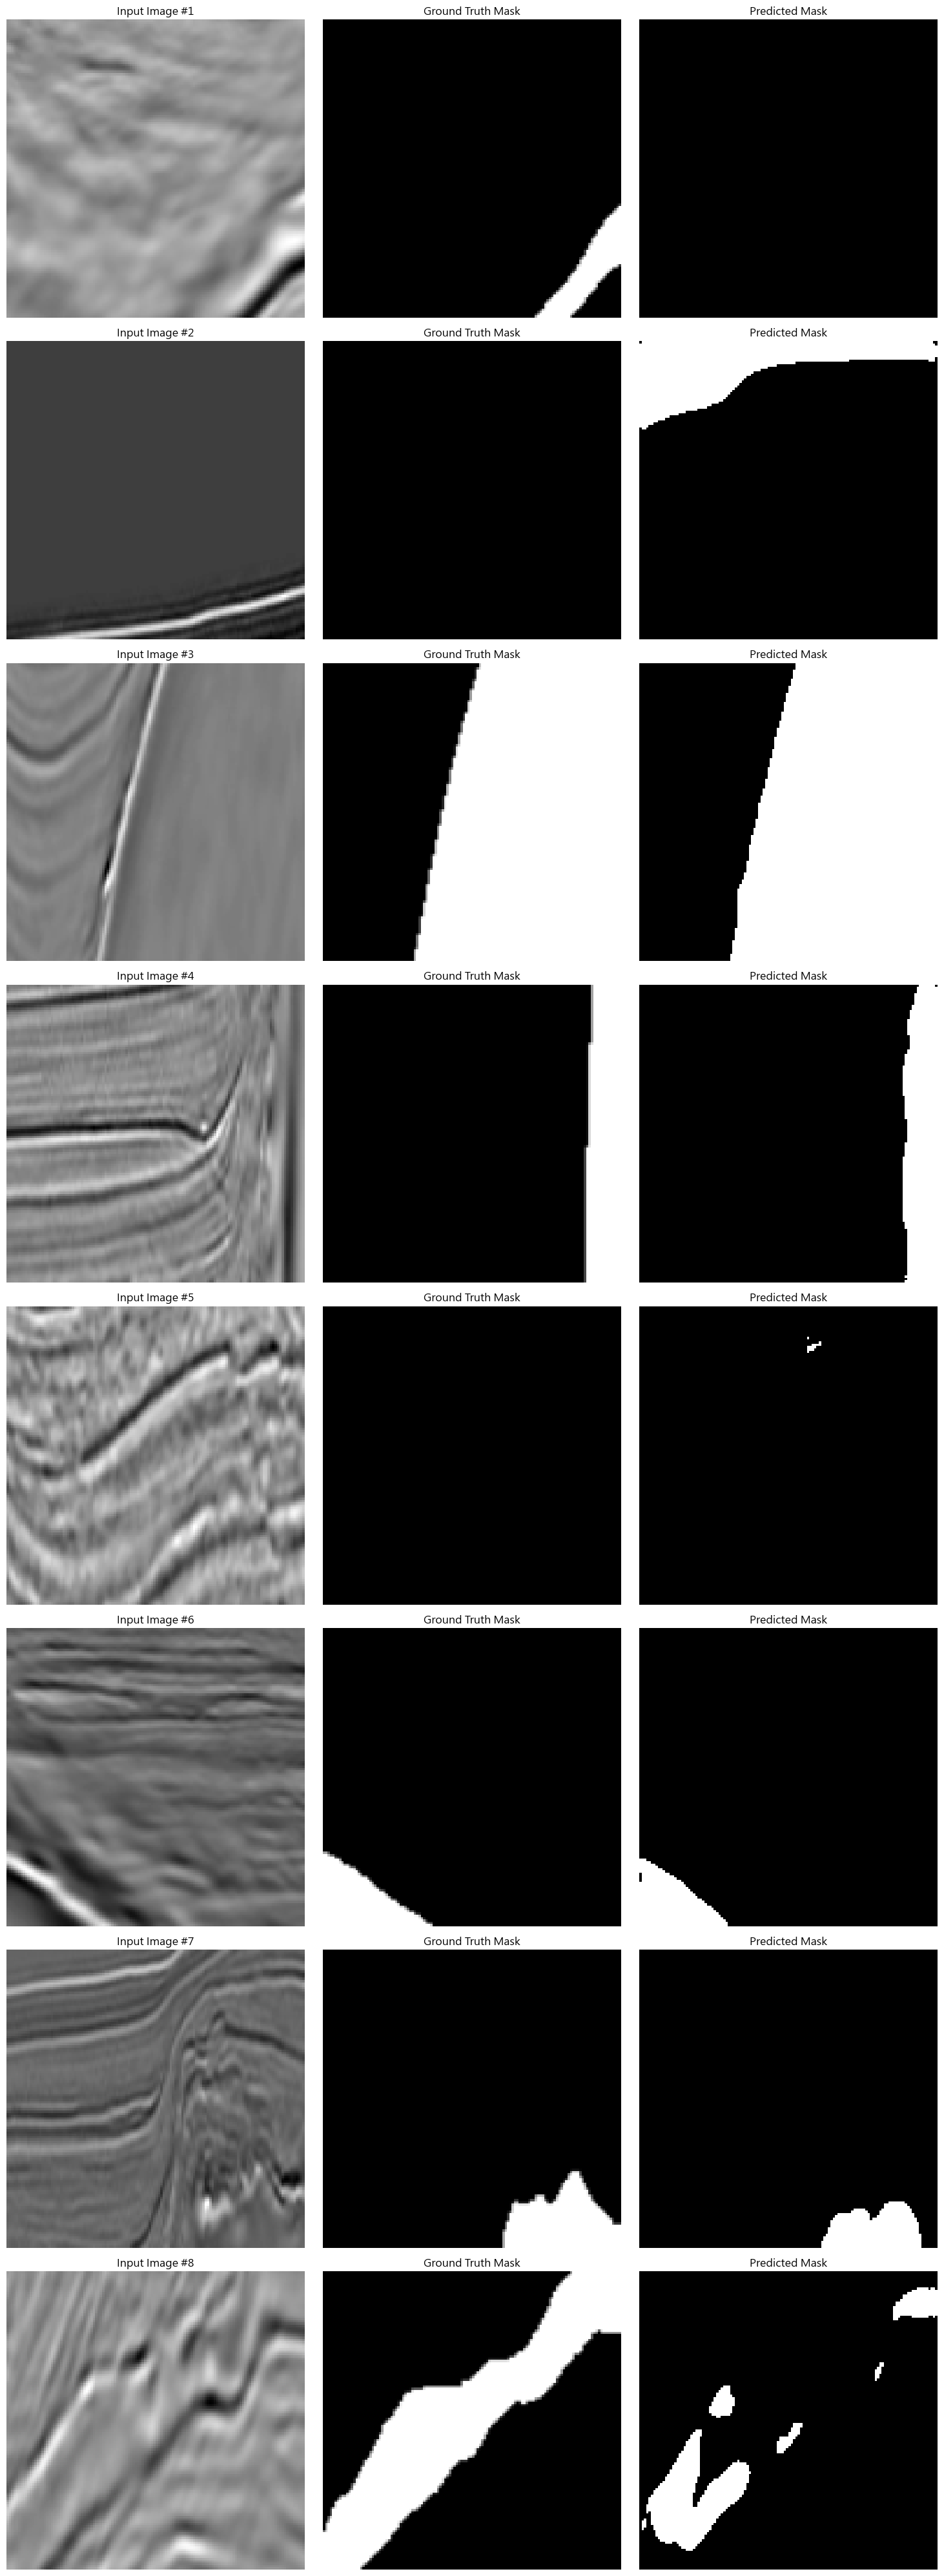

In [6]:
# --- # 步驟 5: 視覺化預測結果 ---
import numpy as np

print("\n--- 顯示模型預測結果 ---")

# --- 從驗證集中找出一個包含鹽體（非全黑遮罩）的批次 ---
print("正在從驗證集中搜尋包含鹽體的樣本...")
found_batch = None
for batch_images, batch_masks in val_loader:
    if batch_masks.sum() > 0:
        print("找到了！")
        found_batch = (batch_images, batch_masks)
        break

if found_batch:
    images, masks = found_batch
else:
    print("警告：在驗證集中沒有找到任何包含鹽體的樣本，將使用第一批資料顯示。")
    images, masks = next(iter(val_loader))
# --- 搜尋結束 ---


# 將找到的圖片移動到 GPU 進行預測
images = images.to(DEVICE)

# 讓模型進行預測
model.eval()
with torch.no_grad():
    outputs = model(images)

# 將模型的 logits 輸出轉換為 0 或 1 的二元遮罩
preds = torch.sigmoid(outputs)
preds = (preds > 0.5).cpu() # 將預測結果移回 CPU 以便繪圖

# 設置畫布大小
# 我們將並排顯示：輸入影像、真實遮罩、預測遮罩
plt.figure(figsize=(15, 5 * BATCH_SIZE))

for i in range(BATCH_SIZE):
    # 繪製輸入影像
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 1)
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Input Image #{i+1}")
    ax.axis('off')

    # 繪製真實遮罩
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 2)
    ax.imshow(masks[i].cpu().squeeze(), cmap='gray')
    ax.set_title("Ground Truth Mask")
    ax.axis('off')

    # 繪製模型預測的遮罩
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 3)
    ax.imshow(preds[i].squeeze(), cmap='gray')
    ax.set_title("Predicted Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import cv2 # 匯入 OpenCV
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 定義 Albumentations 轉換流程 ---
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
    A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
    A.RandomCrop(height=128, width=128, always_apply=True),
    A.GaussNoise(p=0.2),
    A.Perspective(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# --- 2. 更新後的 TgsSaltDataset ---
class TgsSaltDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transforms=None):
        super().__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transforms
        self.image_names = sorted(os.listdir(self.image_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, image_name)
        
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # 將遮罩的像素值從 (0, 255) 轉換為 (0.0, 1.0) 並加上通道維度
        # Albumentations 的 ToTensorV2 會處理 image，但 mask 需要手動處理
        mask = (mask.float() / 255.0).unsqueeze(0)
        
        return image, mask

# 3. 初始化模型、損失函數、優化器
# n_channels=1 因為輸入是灰階圖
# n_classes=1 因為是二元分割，輸出一個代表「是鹽體機率」的 channel
model = UNet(n_channels=1, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 輔助函式：計算 Dice 係數
def dice_coefficient(preds, targets, smooth=1e-6):
    # 1. 將模型的 Logits 輸出通過 Sigmoid 轉換為 0-1 之間的機率
    preds = torch.sigmoid(preds)
    
    # 2. 以 0.5 為門檻，將機率轉換為 0 或 1 的預測遮罩
    preds = (preds > 0.5).float()
    
    # 3. 展平 (flatten) 預測和目標，方便計算
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)
    
    # 4. 計算交集
    intersection = (preds * targets).sum()
    
    # 5. 計算 Dice 分數
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice


# --- 4. 完整訓練與驗證流程 ---
# 設定參數
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 如果 GPU 記憶體不足，可以調低此數值
EPOCHS = 20 # 我們將使用更長的訓練時間
LR = 1e-3

# 準備資料
full_dataset = TgsSaltDataset(
    image_dir='./train/images/', 
    mask_dir='./train/masks/',
    # 注意：此處先不傳入 transform，我們將在 split 後分別傳入
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# 為分割後的 dataset 分別賦予對應的 transform
train_subset.dataset.transforms = train_transforms
val_subset.dataset.transforms = val_transforms

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

# 初始化模型、損失函數、優化器
model = UNet(n_channels=1, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(f"使用的裝置: {DEVICE}")
print("開始使用 Albumentations 進行訓練...")

# 訓練與驗證迴圈
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks).item()

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Dice Score: {val_dice/len(val_loader):.4f}")

print("\n優化訓練完成!")

C:\Users\as123\AppData\Local\Temp\ipykernel_30228\658948244.py:16: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
C:\Users\as123\AppData\Local\Temp\ipykernel_30228\658948244.py:17: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  A.RandomCrop(height=128, width=128, always_apply=True),


使用的裝置: cuda
開始使用 Albumentations 進行訓練...
Epoch 1/20, Train Loss: 0.4299, Val Loss: 0.3711, Val Dice Score: 0.6654
Epoch 2/20, Train Loss: 0.3435, Val Loss: 0.2946, Val Dice Score: 0.7245
Epoch 3/20, Train Loss: 0.2998, Val Loss: 0.2800, Val Dice Score: 0.7274
Epoch 4/20, Train Loss: 0.2877, Val Loss: 0.2497, Val Dice Score: 0.7800
Epoch 5/20, Train Loss: 0.2763, Val Loss: 0.2269, Val Dice Score: 0.7907
Epoch 6/20, Train Loss: 0.2593, Val Loss: 0.2249, Val Dice Score: 0.7843
Epoch 7/20, Train Loss: 0.2517, Val Loss: 0.2191, Val Dice Score: 0.7983
Epoch 8/20, Train Loss: 0.2483, Val Loss: 0.2277, Val Dice Score: 0.7789
Epoch 9/20, Train Loss: 0.2353, Val Loss: 0.1909, Val Dice Score: 0.8251
Epoch 10/20, Train Loss: 0.2154, Val Loss: 0.2003, Val Dice Score: 0.8195
Epoch 11/20, Train Loss: 0.2145, Val Loss: 0.1876, Val Dice Score: 0.8333
Epoch 12/20, Train Loss: 0.2156, Val Loss: 0.2058, Val Dice Score: 0.8235
Epoch 13/20, Train Loss: 0.2031, Val Loss: 0.1889, Val Dice Score: 0.8407
Epoch 1


--- 顯示模型預測結果 ---
正在從驗證集中搜尋包含鹽體的樣本...
找到了！


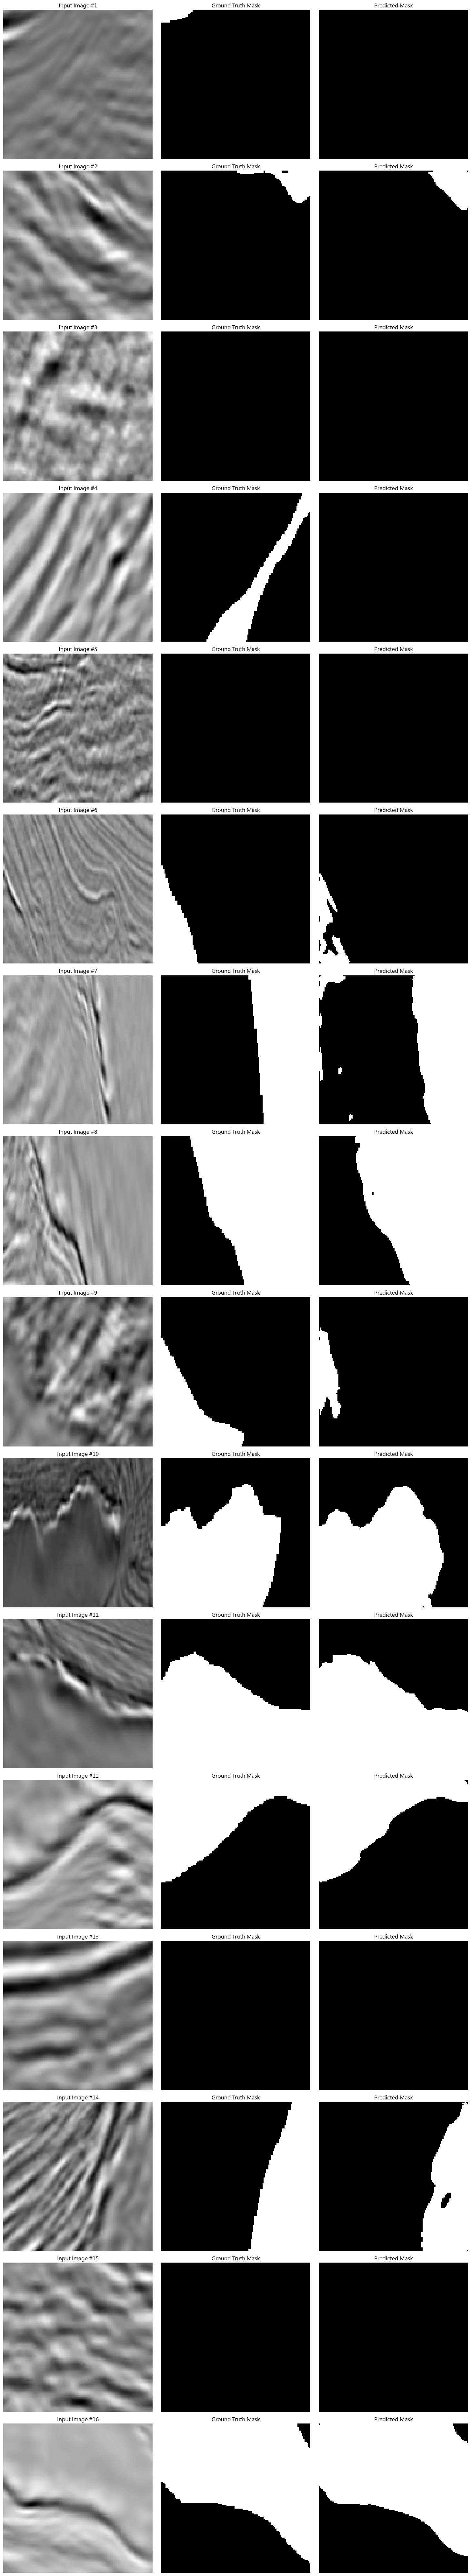

In [9]:
# --- # 步驟 5: 視覺化預測結果 ---
import numpy as np

print("\n--- 顯示模型預測結果 ---")

# --- 從驗證集中找出一個包含鹽體（非全黑遮罩）的批次 ---
print("正在從驗證集中搜尋包含鹽體的樣本...")
found_batch = None
for batch_images, batch_masks in val_loader:
    if batch_masks.sum() > 0:
        print("找到了！")
        found_batch = (batch_images, batch_masks)
        break

if found_batch:
    images, masks = found_batch
else:
    print("警告：在驗證集中沒有找到任何包含鹽體的樣本，將使用第一批資料顯示。")
    images, masks = next(iter(val_loader))
# --- 搜尋結束 ---


# 將找到的圖片移動到 GPU 進行預測
images = images.to(DEVICE)

# 讓模型進行預測
model.eval()
with torch.no_grad():
    outputs = model(images)

# 將模型的 logits 輸出轉換為 0 或 1 的二元遮罩
preds = torch.sigmoid(outputs)
preds = (preds > 0.5).cpu() # 將預測結果移回 CPU 以便繪圖

# 設置畫布大小
# 我們將並排顯示：輸入影像、真實遮罩、預測遮罩
plt.figure(figsize=(15, 5 * BATCH_SIZE))

for i in range(BATCH_SIZE):
    # 繪製輸入影像
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 1)
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Input Image #{i+1}")
    ax.axis('off')

    # 繪製真實遮罩
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 2)
    ax.imshow(masks[i].cpu().squeeze(), cmap='gray')
    ax.set_title("Ground Truth Mask")
    ax.axis('off')

    # 繪製模型預測的遮罩
    ax = plt.subplot(BATCH_SIZE, 3, i * 3 + 3)
    ax.imshow(preds[i].squeeze(), cmap='gray')
    ax.set_title("Predicted Mask")
    ax.axis('off')

plt.tight_layout()
plt.show()